#### Projet final du Kit Data Science 2021
Le projet final du Kit Data Science 2021 porte sur les données du Vendée Globe 2020-2021.

Le projet se déroule 26 octobre au 5 novembre 2021 date limite pour rendre vos projets respectifs.

Les données du dernier Vendée Globe sont disponibles sous la forme de fichiers Excel avec les classements fournis plusieurs fois par jour par les organisateurs de la course. Il y a également une page web avec une fiche technique par voilier qui contient des informations techniques et qu'il est possible de rapprocher des classements.

Il vous appartient de charger les données en Python, de procéder aux préparations nécessaires et d'effectuer les analyses pertinentes de votre choix.

Le rendu sera un notebook Jupyter fourni aux formats ipynb et HTML.

#### Barème sur 15 points :

- Acquisition et chargement des données : 3 points
- Préparation des données : 5 points
- Analyses et story telling : 7 points
- Exemples de traitements et d'analyses :

#### Récupération des fichiers Excel avec les classements

- Mettre en place une copie locale des fichiers Excel afin de ne pas les recharger à chaque run.
- Vers la fin de la course le format des fichiers Excel change avec les arrivées des voiliers : il est possible de s'arrêter juste avant.

- Extraction des caractéristiques techniques de chacun des voiliers.

- Rapprochement des données des voiliers avec celle des classements.
 
- Corrélation et régression linéaire entre le classement (rang) et la vitesse utile (VMG) des voiliers.
- Impact de la présence d'un foil sur le classement et la vitesse des voiliers.
- Visualisation de la distance parcourue par voilier.
- Cartes avec les routes d'un ou plusieurs voiliers.
- Analyses de séries temporelles.
- Application d'algorithmes statistiques ou de machine learning.
- etc.

#### Sources des données

- Page web donnant accès aux fichiers Excel des classements du Vendée Globe : https://www.vendeeglobe.org/fr/classement
- Page web avec les fiches techniques des voiliers du Vendée Globe : https://www.vendeeglobe.org/fr/glossaire
- Site web donnant accès à des fichiers avec les formes géométriques des côtes : https://www.naturalearthdata.com/ (ou bien utilisez les librairies plotly ou ipyleaflet pour produire des cartes)
- etc.

#### Questions/Réponses

Les questions et réponses seront publiées ci-après au fil de l'eau :

Qu'est-ce qu'un foil ? https://www.vendeeglobe.org/fr/actualites/19755/quels-foils-pour-gagner-le-vendee-globe La présence d'un foil est indiqué dans l'attribut "Nombre de dérives" dans les fiches techniques des voiliers.
S'agit-il d'un travail individuel ou collectif ? Il s'agit bien d'un travail individuel.
Est-il possible de rendre plusieurs notebooks afin de délimiter clairement les différentes étapes du projet ? Tout peut tenir dans un seul notebook mais pourquoi pas.
Avertissement

Vous devez publier votre notebook exécuté aux formats ipynb et HTML sur votre github avant le vendredi 5 novembre 2021 à 23h59 et lorsque c'est fait envoyer une notification par email avec le lien du projet à l'adresse contact(at)yotta-conseil.fr

Bon projet !

In [1]:
import requests
import urllib.request
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import ipdb
import glob
import xlwings
from datetime import datetime
import re
from lat_lon_parser import parse
import warnings
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

plt.rcParams["figure.figsize"] = (10,10)
plt.rc('xtick', labelsize=15) 
plt.rc('ytick', labelsize=15)

warnings.filterwarnings("ignore")

# Téléchargement des classements (fichiers Excel)

In [2]:
url_ranking = "https://www.vendeeglobe.org/fr/classement"

In [3]:
# fonction qui permet d'ouvrir et sauvegarder un fichier Excel (résout le bug de lecture des fichiers de pd.read_excel)
def xlsx_broken(file):
    excel_app = xlwings.App(visible=False)
    excel_book = excel_app.books.open(file)
    excel_book.save()
    excel_book.close()
    excel_app.quit()
    return

In [4]:
# # Récupération de tous les url des fichiers Excel à télécharger
# r_excel_files = requests.get(url_ranking)
# soup_excel_files = BeautifulSoup(r_excel_files.content,'html.parser')
# 
# options = soup_excel_files.find(class_="form__input m--select onsubmit-rank").find_all('option')[1:]
# 
# # Récupération des noms des fichiers
# url_files_root = "https://www.vendeeglobe.org/download-race-data/"
# lst_dates = []
# lst_nomfichier = []
# 
# # Itération sur toutes les balises "option value" pour récupérer la date du fichier et le nom associé
# for option in options:
#     lst_nomfichier.append("vendeeglobe_" + option['value'] + ".xlsx")
#     lst_dates.append(option.text[2:])
#     
# # Téléchargement des fichiers
# for nomfichier in lst_nomfichier:
#     urllib.request.urlretrieve(url_files_root+ nomfichier, "data/"+ nomfichier)

In [5]:
# # Ouverture et sauvegarde de chaque fichier pour pouvoir les read_excel
# for file in lst_files:
#     xlsx_broken(file)

# Extraction des classements

In [6]:
# lst_files = glob.glob("data/*")
# df_rank = None
# 
# col_template = pd.read_excel(lst_files[0],header=[1],skiprows=3).columns
# 
# # Concaténation des différents fichiers ----------------------------------
# for file in lst_files:
#     
#     # Récupération des données du fichier
#     df_temp = pd.read_excel(file,header=[1],skiprows=3)
# 
#     # Cas où le format du fichier est celui des dernières dates
#     if df_temp[df_temp.iloc[:,4]=="Heure FR\nHour FR"].shape[0] > 0:
#         
#         # Recherche de la ligne à laquelle les données commencent
#         idx = df_temp[df_temp.iloc[:,4]=="Heure FR\nHour FR"].index[0]+1
#         
#         # Suppression des lignes précédentes
#         df_temp.drop(index = range(0,idx), inplace=True)
#         df_temp.reset_index(drop=True, inplace=True)
#         
#         # Remplacement des colonnes avec les bons noms
#         df_temp.columns = col_template
# 
#     # Suppression des 4 dernières lignes
#     df_temp.drop(index = range(df_temp.shape[0]-4,df_temp.shape[0]),inplace=True)
#     
#     # Ajout d'une colonne avec la date et l'heure
#     str_date = file[17:32]
#     year,month,day,hour = int(str_date[0:4]),int(str_date[4:6]),int(str_date[6:8]),int(str_date[9:11])+2
#     date = datetime(year=year,month=month,day=day,hour=hour)
#     df_temp.insert(0,'Date',date)
#     
#     # Ajout au DataFrame final
#     df_rank = pd.concat([df_rank,df_temp],axis = 0)
# 
# 
# # Nettoyage des données --------------------------------------------------
# df_rank = df_rank.T.reset_index(drop=True).T
# df_rank.drop(1,inplace=True,axis=1)
# df_rank = df_rank.T.reset_index(drop=True).T
# df_rank.reset_index(drop=True,inplace=True)
# 
# colonnes = ["Date","Rang","Code voile","Skipper","Heure","Latitude","Longitude","30min Cap","30min Vitesse","30min VMG","30min Distance","Depuis Dernier Classement Cap","Depuis Dernier Classement Vitesse","Depuis Dernier Classement VMG","Depuis Dernier Classement Distance","24h Cap","24h Vitesse","24h VMG","24h Distance","DTF","DTL"]
# df_rank.columns= colonnes
# 
# df_rank.insert(3,"Nom Voile","")
# 
# df_rank[['Skipper', 'Nom Voile']] = df_rank['Skipper'].str.split("\n", expand=True)
# 
# df_rank.replace(r'\n', '', regex=True, inplace=True)
# 
# for col in df_rank.columns[8:]:
#     df_rank[col] =df_rank[col].apply(lambda x: re.sub('[^\d\.]', '', str(x)))
# 
# df_rank['Latitude'] =df_rank['Latitude'].apply(lambda x: np.nan if pd.isnull(x)  else parse(str(x)) )
# df_rank['Longitude'] =df_rank['Longitude'].apply(lambda x: np.nan if pd.isnull(x)  else parse(str(x)) )
# df_rank.drop(df_rank[df_rank['Rang']=='RET'].index, inplace=True)
# df_rank.drop(df_rank[df_rank['Rang']=='NL'].index, inplace=True)
# df_rank.reset_index(drop=True,inplace=True)
# df_rank['Skipper'] = df_rank['Skipper'].apply(lambda x: str(x).lower())
# df_rank['Rang'] = df_rank['Rang'].astype('int64')
# 
# df_rank.to_csv("all_data.csv",index=False)

In [7]:
df_rank=pd.read_csv("all_data.csv")
df_rank

,Date,Rang,Code voile,Nom Voile,Skipper,Heure,Latitude,Longitude,30min Cap,30min Vitesse,...,Depuis Dernier Classement Cap,Depuis Dernier Classement Vitesse,Depuis Dernier Classement VMG,Depuis Dernier Classement Distance,24h Cap,24h Vitesse,24h VMG,24h Distance,DTF,DTL
0,2020-11-08 16:00:00,1,FRA 18,Bureau Vallée 2,louis burton,15:30 FR,46.407667,-1.841333,241,17.7,...,357,0.0,0.0,2788.0,201,0.3,0.3,6.1,24293.9,0.0
1,2020-11-08 16:00:00,2,MON 10,Seaexplorer - Yacht Club De Monaco,boris herrmann,15:31 FR1min,46.405667,-1.830333,241,11.1,...,357,0.0,0.0,2787.9,196,0.3,0.2,6.0,24294.2,0.4
2,2020-11-08 16:00:00,3,FRA 8,Charal,jérémie beyou,15:30 FR,46.415167,-1.833167,244,15.5,...,357,0.0,0.0,2788.5,199,0.2,0.2,5.5,24294.3,0.5
3,2020-11-08 16:00:00,4,FRA 59,LinkedOut,thomas ruyant,15:30 FR,46.411833,-1.828000,244,13.2,...,357,0.0,0.0,2788.3,196,0.2,0.2,5.6,24294.5,0.6
4,2020-11-08 16:00:00,5,FRA 53,V And B Mayenne,maxime sorel,15:30 FR,46.409833,-1.826000,246,10.9,...,357,0.0,0.0,2788.1,195,0.8,0.7,5.8,24294.5,0.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15267,2021-03-04 13:00:00,25,FIN 222,Stark,ari huusela,11:30 FR,47.151833,-5.585167,19,5.7,...,28,7.6,2.8,22.7,66,8.2,7.9,196.5,161.4,0.0
15268,2021-03-04 16:00:00,25,FIN 222,Stark,ari huusela,14:30 FR,47.213667,-5.344833,106,6.7,...,69,3.5,2.9,10.5,62,7.4,7.1,178.8,152.8,0.0
15269,2021-03-04 19:00:00,25,FIN 222,Stark,ari huusela,17:30 FR,47.182167,-4.706000,94,10.0,...,94,8.7,8.5,26.1,62,7.2,6.9,172.2,127.4,0.0
15270,2021-03-04 23:00:00,25,FIN 222,Stark,ari huusela,21:30 FR,47.140667,-3.815000,107,8.7,...,94,9.1,8.8,36.5,68,7.1,6.9,170.9,92.7,0.0


# Extraction des caractéristiques des voiliers

In [8]:
url_features = "https://www.vendeeglobe.org/fr/glossaire"

In [9]:
r_features = requests.get(url_features)
soup_features = BeautifulSoup(r_features.content,'html.parser')
boat_tags = soup_features.find_all(class_="sv-u-1 sv-u-s-1-2 sv-u-m-1-3 sv-u-l-1-6")

In [10]:
dict_boats = {
    "Numéro de voile":[],
    "Nom de voile":[],
    "Propriétaire":[],
    "Anciens noms du bateau":[],
    "Architecte":[],
    "Chantier":[],
    "Date de lancement":[],
    "Longueur":[],
    "Largeur":[],
    "Tirant d'eau":[],
    "Déplacement (poids)":[],
    "Nombre de dérives":[],
    "Hauteur mât":[],
    "Voile quille":[],
    "Surface de voiles au près":[],
    "Surface de voiles au portant":[]
}


for tag in boat_tags:
    # Nom du bateau
    dict_boats["Nom de voile"].append(tag.find(class_="boats-list__boat-name").text)
    
    # Propriétaire
    dict_boats["Propriétaire"].append(tag.find(class_="boats-list__skipper-name").text)
    
    #ipdb.set_trace()
    # --------------------------------------------------------------------
    lst_features = tag.find_all(class_="boats-list__popup-specs-list")[0].find_all("li")
    
    # Ajout des caractéristiques des bateaux
    for feature in lst_features:
        for key in dict_boats.keys():
            if key in feature.text:
                if key == 'Numéro de voile':
                    code_voile = feature.text.split(' : ')[1]
                    #ipdb.set_trace()
                    if bool(re.match(r'[0-9]+',code_voile)):
                        code_voile = 'FRA ' + code_voile
                    elif not ' ' in code_voile:
                        code_voile = ' '.join(re.match(r"([A-Z]+)([0-9]+)", code_voile, re.I).groups())
                    dict_boats[key].append(code_voile)
                else:
                    dict_boats[key].append(feature.text.split(' : ')[1])
                
                break
    
    #Ajout d'un np.nan dans les listes si l'élément n'a pas été trouvé dans la liste des features
    max_len = max([len(col) for col in dict_boats.values()])
    for key in dict_boats.keys():
        if len(dict_boats[key])<max_len:
            dict_boats[key].append(np.nan)
    
    
df_voiles = pd.DataFrame(dict_boats)

In [11]:
# Retraitement des données numériques

df_voiles_retraite = df_voiles.copy()

# Transformation des valeurs manquantes (notées "nc" ou "NC") en NaN
df_voiles_retraite.replace(r"[nN][cC]",np.nan,regex = True,inplace = True)

# Transformation des string en valeurs numériques
for col in ['Surface de voiles au près','Surface de voiles au portant']:
    df_voiles_retraite[col] = df_voiles[col].str[:-3].astype('int64')
    
for col in ["Hauteur mât", "Tirant d'eau", "Longueur", "Largeur", "Déplacement (poids)"]:
    df_voiles_retraite[col] = df_voiles_retraite[col].str.replace('[a-z ]',"").str.replace(',','.').astype('float')

df_voiles_retraite['Propriétaire']=df_voiles_retraite['Propriétaire'].apply(lambda x: str(x).lower())
df_voiles_retraite['Propriétaire'][11] = "samantha davies"
df_voiles_retraite['Propriétaire'][23] = "giancarlo pedote"
df_voiles_retraite['Propriétaire'][24] = "alan roura"
df_voiles_retraite['Propriétaire'][5] = "arnaud boissieres"
df_voiles_retraite=df_voiles_retraite.sort_values(['Propriétaire'])
df_voiles_retraite

,Numéro de voile,Nom de voile,Propriétaire,Anciens noms du bateau,Architecte,Chantier,Date de lancement,Longueur,Largeur,Tirant d'eau,Déplacement (poids),Nombre de dérives,Hauteur mât,Voile quille,Surface de voiles au près,Surface de voiles au portant
24,SUI 07,LA FABRIQUE,alan roura,"Brit Air, Votre Nom autour du Monde, MACSF",Groupe Finot-Conq,Multiplast,01 Août 2007,18.28,5.90,4.5,NaN,foils,27.0,carbone,290,580
30,GBR 99,HUGO BOSS,alex thomson,NaN,VPLP - Alex Thomson Racing (led by Pete Hobson),Carrington Boats,15 Août 2019,18.28,5.40,4.5,7.7,foils,29.0,acier forgé,330,630
2,FRA 72,TSE - 4MYPLANET,alexia barrier,"Famille Mary-Etamine du Lys, Initiatives Coeur...",Marc Lombard,NaN,01 Mars 1998,18.28,5.54,4.5,9.0,2,29.0,acier,260,580
18,FIN 222,STARK,ari huusela,"Aviva, GAES Centros Auditivos",Owen Clarke Design,Hakes Marine - Wellington (Nouvelle-Zélande),06 Août 2007,18.28,5.80,4.5,8.5,2,28.0,acier,270,580
31,FRA 2,NaN,armel tripon,NaN,Samuel Manuard,Black Pepper©,31 Janvier 2020,18.28,5.50,4.5,7.8,foils,28.0,acier forgé,270,535
5,FRA 14,LA MIE CÂLINE - ARTISANS ARTIPÔLE,arnaud boissieres,"Ecover3, Président, Gamesa, Kilcullen Voyager-...",Owen Clarke Design LLP - Clay Oliver,Hakes Marine - Mer Agitée,03 Août 2007,18.28,5.65,4.5,7.9,foils,29.0,basculante avec vérin,300,610
13,FRA 09,OMIA - WATER FAMILY,benjamin dutreux,"Spirit of Yukoh, Neutrogena, Hugo Boss, Estrel...",Bruce Farr Design,Offshore Challenge - Cowes,03 Juillet 2007,18.28,5.85,4.5,8.0,2,29.0,acier forgé,300,700
17,FRA 16,SEAEXPLORER - YACHT CLUB DE MONACO,boris herrmann,"Edmond de Rothschild, Malizia - Yacht Club de ...",Verdier - VPLP,Multiplast,07 Août 2015,18.28,5.70,4.5,7.6,foils,29.0,acier,290,490
10,FRA 79,APIVIA,charlie dalin,NaN,Verdier,NaN,05 Août 2019,18.28,5.85,4.5,8.0,foils,29.0,acier,350,560
9,FRA 30,BANQUE POPULAIRE X,clarisse cremer,Macif - SMA,Verdier - VPLP,CDK - Mer Agitée,01 Mars 2011,18.28,5.70,4.5,7.7,2,29.0,acier forgé,340,570


In [12]:
for col in df_voiles_retraite.columns[7:]:
    dict_ = dict(zip(df_voiles_retraite['Propriétaire'], df_voiles_retraite[col]))
    df_rank.insert(df_rank.shape[1],col,df_rank['Skipper'])
    df_rank[col]=df_rank[col].map(dict_)
df_rank

,Date,Rang,Code voile,Nom Voile,Skipper,Heure,Latitude,Longitude,30min Cap,30min Vitesse,...,DTL,Longueur,Largeur,Tirant d'eau,Déplacement (poids),Nombre de dérives,Hauteur mât,Voile quille,Surface de voiles au près,Surface de voiles au portant
0,2020-11-08 16:00:00,1,FRA 18,Bureau Vallée 2,louis burton,15:30 FR,46.407667,-1.841333,241,17.7,...,0.0,18.28,5.80,4.5,7.6,foils,28.0,acier,300,600
1,2020-11-08 16:00:00,2,MON 10,Seaexplorer - Yacht Club De Monaco,boris herrmann,15:31 FR1min,46.405667,-1.830333,241,11.1,...,0.4,18.28,5.70,4.5,7.6,foils,29.0,acier,290,490
2,2020-11-08 16:00:00,3,FRA 8,Charal,jérémie beyou,15:30 FR,46.415167,-1.833167,244,15.5,...,0.5,18.28,5.85,4.5,8.0,foils,29.0,acier,320,600
3,2020-11-08 16:00:00,4,FRA 59,LinkedOut,thomas ruyant,15:30 FR,46.411833,-1.828000,244,13.2,...,0.6,18.28,5.85,4.5,8.0,foils,29.0,acier forgé,350,560
4,2020-11-08 16:00:00,5,FRA 53,V And B Mayenne,maxime sorel,15:30 FR,46.409833,-1.826000,246,10.9,...,0.6,18.28,5.50,4.5,7.7,2,29.0,acier,365,700
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15267,2021-03-04 13:00:00,25,FIN 222,Stark,ari huusela,11:30 FR,47.151833,-5.585167,19,5.7,...,0.0,18.28,5.80,4.5,8.5,2,28.0,acier,270,580
15268,2021-03-04 16:00:00,25,FIN 222,Stark,ari huusela,14:30 FR,47.213667,-5.344833,106,6.7,...,0.0,18.28,5.80,4.5,8.5,2,28.0,acier,270,580
15269,2021-03-04 19:00:00,25,FIN 222,Stark,ari huusela,17:30 FR,47.182167,-4.706000,94,10.0,...,0.0,18.28,5.80,4.5,8.5,2,28.0,acier,270,580
15270,2021-03-04 23:00:00,25,FIN 222,Stark,ari huusela,21:30 FR,47.140667,-3.815000,107,8.7,...,0.0,18.28,5.80,4.5,8.5,2,28.0,acier,270,580


In [13]:
df_rank.dtypes

Date                                   object
Rang                                    int64
Code voile                             object
Nom Voile                              object
Skipper                                object
Heure                                  object
Latitude                              float64
Longitude                             float64
30min Cap                               int64
30min Vitesse                         float64
30min VMG                             float64
30min Distance                        float64
Depuis Dernier Classement Cap           int64
Depuis Dernier Classement Vitesse     float64
Depuis Dernier Classement VMG         float64
Depuis Dernier Classement Distance    float64
24h Cap                                 int64
24h Vitesse                           float64
24h VMG                               float64
24h Distance                          float64
DTF                                   float64
DTL                               

# Analyse

### Rang et VMG

Coefficients de régression -------------------------------------------
Depuis Dernier Classement VMG  : -0.62
30min VMG  : -0.54
24h VMG  : -0.86
----------------------------------------------------------------------


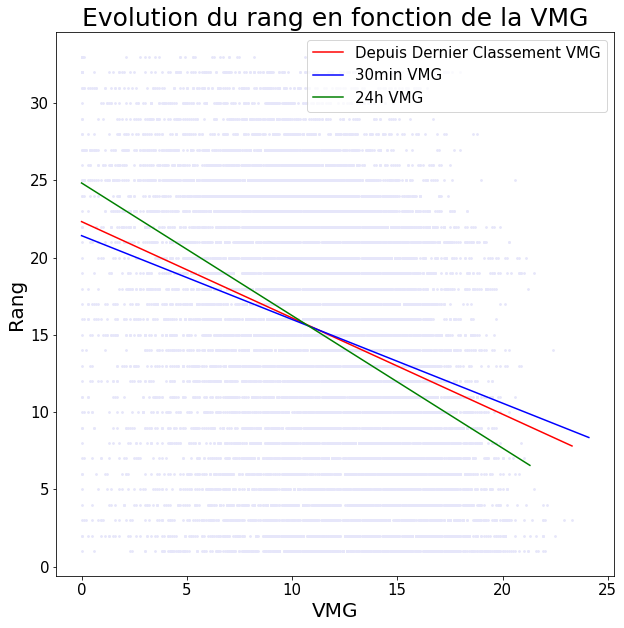

In [14]:
x1_name = 'Depuis Dernier Classement VMG'
x2_name = '30min VMG'
x3_name = '24h VMG'
x1 = df_rank['Depuis Dernier Classement VMG']
x2 = df_rank['30min VMG']
x3 = df_rank['24h VMG']
y = df_rank['Rang']

plt.scatter(x1,y,s=3,color='lavender')
plt.xlabel('VMG',fontsize=20)
plt.ylabel('Rang',fontsize=20)


coeffs = []
lst_var_name = [x1_name,x2_name,x3_name]
lst_var = [x1,x2,x3]
colors = ['red','blue','green']
for i in range(0,3):
    
    x_prime = np.linspace(min(lst_var[i]), max(lst_var[i]), num=lst_var[i].shape[0])
    b, a = np.polynomial.polynomial.polyfit(lst_var[i], y, 1)
    plt.plot(x_prime, b + a * x_prime, '-',zorder=1,color=colors[i],label = lst_var_name[i])
    coeffs.append(a)

print("Coefficients de régression " + "-" * 43)
for i in range(0,3):
    print(lst_var_name[i], " : %.2f" % (coeffs[i]))
print('-'*70)
plt.legend(fontsize=15)
plt.title('Evolution du rang en fonction de la VMG',fontsize=25)
plt.show()

Nous pouvons voir qu'il existe un lien important entre le rang et la VMG. En effet, une augmentation de 1 point de VMG permet une augmentation de 0.54 à 0.86 dans le classement, soit une demi place. La droite indique également que plus la VMG est élevée, plus le skipper a de chances d'être bien classé, ce qui est cohérent.

### Rang et foils

In [15]:
#Ajout d'une d'un dummy dans df_rank qui vaut 1 si présence de foils, 0 sinon

dict1 = dict(zip(df_voiles_retraite['Propriétaire'], df_voiles_retraite['Nombre de dérives']))
dict2 = {"foiler":1,"2":0,"2 asymétriques":0,"foils":1}
try:
    df_rank.insert(df_rank.shape[1],"foil",df_rank['Skipper'])
except:
    df_rank['foil'] = df_rank['Skipper']
df_rank['foil']=df_rank['foil'].map(dict1).map(dict2)

In [16]:
x_name = 'foil'
x = pd.DataFrame(df_rank[x1_name])
y = pd.DataFrame(df_rank['Rang'])

reg = LinearRegression()
reg.fit(x,y)

coeff_reg = reg.coef_[0][0]
intercept = reg.intercept_[0]

print("Résultats de la régression " + "-" * 43)
print("\n  Constante :",np.round(intercept,3))
print("  Coeff :",np.round(coeff_reg,3))
print('\n'+'-'*70)

Résultats de la régression -------------------------------------------

  Constante : 22.334
  Coeff : -0.623

----------------------------------------------------------------------


Il semble exister un lien entre position dans le classement et foils : le fait d'être équipé en foils permet d'augmenter sa position dans le classement à hauteur de 5 places environ.

### Vitesse et foils

In [17]:
# Comme indicateur de vitesse, prenons la moyenne entre les trois VMG fournies
VMG_avg = pd.DataFrame(pd.concat([df_rank['Depuis Dernier Classement VMG'],df_rank['30min VMG'], df_rank['24h VMG']],axis=1).mean(axis=1))

x_name = 'foil'
x = pd.DataFrame(df_rank[x1_name])
y = VMG_avg

reg = LinearRegression()
reg.fit(x,y)

coeff_reg = reg.coef_[0][0]
intercept = reg.intercept_[0]

print("Résultats de la régression " + "-" * 43)
print("\n  Constante :",np.round(intercept,3))
print("  Coeff :",np.round(coeff_reg,3))
print('\n'+'-'*70)

Résultats de la régression -------------------------------------------

  Constante : 1.446
  Coeff : 0.867

----------------------------------------------------------------------


Il semble également exister un lien entre équipement en foils et vitesse : posséder au moins un foils entraîne une augmentation de vitesse d'une unité.

# Affichage des trajectoires sur une carte

In [72]:
from ipyleaflet import Map, GeoData, LegendControl
from random import randint
from geopandas import GeoDataFrame
from shapely.geometry import Point

longitudes = pd.DataFrame(df_rank.groupby('Skipper')['Longitude'].apply(list))
latitudes = pd.DataFrame(df_rank.groupby('Skipper')['Latitude'].apply(list))
n_skippers = longitudes.shape[0]

# Récupération du classement final pour n'afficher que le top n
df_classement_final = pd.read_csv('classement_final.csv',sep=';')
df_classement_final.drop(df_classement_final[df_classement_final['Rang']=='RET'].index,inplace=True)
df_classement_final['Rang'] = df_classement_final['Rang'].astype('int64')
top = 5

# Création de la carte
m = Map(center=(-10, 18), zoom=1.5)


# Création des coordonnées des trajectoires des voiles
coord = pd.DataFrame({'liste longitude':longitudes['Longitude'],'liste latitude' : latitudes['Latitude']})

colors = ['dodgerblue','yellow','orange','fuchsia','aquamarine']

dict_legend = {}
j=0

for i in range(0,n_skippers):
    
    skipper = longitudes.index[i]
    
    #Si le skipper est dans le classement final (25 places)
    if skipper in list(df_classement_final["Skipper"]):
        skipper_rank = df_classement_final[df_classement_final["Skipper"]==skipper].iloc[0,0]
        
        #Si le skipper est dans le top 5
        if skipper_rank <= top:

            trajectoire = pd.DataFrame({'Longitude':coord.iloc[i,0],'Latitude' : coord.iloc[i,1]})
            geometry = [Point(xy) for xy in zip(trajectoire['Longitude'], trajectoire['Latitude'])]


            gdf = GeoDataFrame(trajectoire, geometry=geometry) 
            geo_data = GeoData(geo_dataframe = gdf,
                               style={'color': colors[j], 'radius':2, 'opacity':1, 'weight':1.9, 'dashArray':'2', 'fillOpacity':0.6},
                               hover_style={'fillColor': 'red' , 'fillOpacity': 0.2},
                               point_style={'radius': 2, 'color': colors[j], 'fillOpacity': 0.8, 'fillColor': 'blue', 'weight': 3})

            dict_legend[coord.index[i] + " (rank: " + str(skipper_rank)+")" ] = colors[j]

            m.add_layer(geo_data)
            j+=1
        
legend = LegendControl(dict_legend, name="Legend (from 1st rank to last)", position="bottomright")
m.add_control(legend)
m.save('map.html')
m



Map(center=[-10, 18], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_te…

# Distances parcourues

In [101]:
df_dist = pd.DataFrame(df_rank.groupby('Skipper')['Depuis Dernier Classement Distance'].sum())
df_dist.reset_index(inplace=True)
df_dist.sort_values(['Depuis Dernier Classement Distance'],inplace=True, ascending = False)
df_dist.insert(0,'Rang',df_dist['Skipper'])
df_dist['Rang']=df_dist['Rang'].map(dict(zip(df_classement_final['Skipper'],df_classement_final['Rang'])))
df_dist.head()

,Rang,Skipper,Depuis Dernier Classement Distance
17,13.0,jérémie beyou,31813.2
3,25.0,ari huusela,31342.3
19,16.0,kojiro shiraishi,31334.9
21,23.0,manuel cousin,31089.6
28,18.0,stéphane le diraison,30984.0


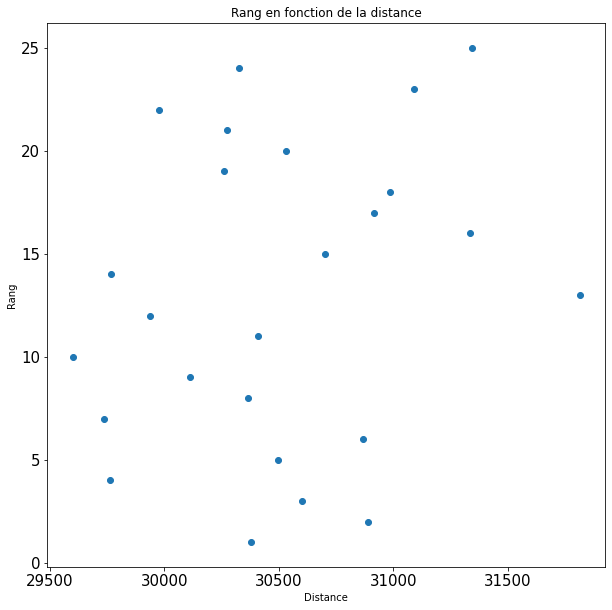

In [128]:
x = pd.DataFrame(df_dist['Depuis Dernier Classement Distance'])
y = pd.DataFrame(df_dist['Rang'])
plt.scatter(x,y)
plt.xlabel('Distance')
plt.ylabel('Rang')
plt.title('Rang en fonction de la distance')
plt.show()

Il apparaît ici que plus la distance parcourue est grande, plus les skippers sont bas dans le classement.

Nous avons donc pu observer que le rang est bien influencé positivement par la vitesse et les foils. Il semble également que les vaiqueurs tendent à parcourir le moins de distance. La victoire réside donc dans une trajectoire optimale compte tenue d'une vitesse plus élevée.